## makemore: becoming a backprop ninja

In [1]:
# there no change change in the first several cells from last lecture

In [254]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [255]:
# read in all the words
words = open('./data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [256]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [257]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [258]:
# ok biolerplate done, now we get to the action:

In [259]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [260]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [261]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [262]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3625, grad_fn=<NegBackward0>)

In [263]:
logprobs[0]

tensor([-2.7214, -2.5053, -3.9953, -2.9545, -3.9240, -2.5503, -3.6896, -3.3337,
        -4.1074, -3.4041, -3.2451, -3.2967, -3.1902, -3.5931, -3.3259, -4.2558,
        -4.7830, -3.9113, -4.1743, -2.8712, -2.9677, -3.8664, -3.6701, -2.6036,
        -2.8282, -3.7217, -3.7468], grad_fn=<SelectBackward0>)

In [264]:
logprobs[range(3), torch.tensor([0, 1, 2])]

tensor([-2.7214, -2.9607, -4.2821], grad_fn=<IndexBackward0>)

In [265]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

# loss = -(a + b + c) / 3
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
cmp('logprobs', dlogprobs, logprobs)

# logprobs = log(a)
# dlogprobs/da = 1 / a
probs.shape
dprobs = (1 / probs) * dlogprobs
cmp('probs', dprobs, probs)

# probs = counts * a
# dprobs/da = counts
# However, here, via broadcasting, counts_sum_inv can be considered a variable that is
# being used multiple times
# In this situation, we accumulate the gradients by adding them all up
# count * dprobs represents what the gradient looks like before getting summarized into one variable
dcounts_sum_inv = torch.sum(counts * dprobs, 1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# counts_sum_inv = counts_sum ** -1
# dcounts_sum_inv/da = -counts_sum ** -2
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

# probs = counts * counts_sum_inv
# dprobs/dcounts = counts_sum_inv
# also
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum = [[a + b], [c + d]]
# dcounts_sum/dcounts = [[1, 1], [1, 1]]
dcounts = dprobs * counts_sum_inv 
dcounts += dcounts_sum # * torch.ones_like(counts)
cmp('counts', dcounts, counts)

# counts = norm_logits.exp()
# dcounts/dnorm_logits = norm_logits.exp()
dnorm_logits = counts * dcounts
# or 
# dnorm_logits = norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

# norm_logits = logits - logit_maxes
# dnorm_logits/dlogit_maxes = -1
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
# verbose
# dlogit_maxes = (-torch.ones_like(dlogit_maxes) * dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

# norm_logits = logits - logit_maxes
# dnorm_logits/dlogits = 1
dlogits = dnorm_logits.clone()

# logit_maxes = logits.max(1, keepdim=True).values
# dlogit_maxes = 1 for the max in each row
# Theoretically, this shouldn't be necessary
# as logit_maxes are only added for numerical stability
# So the gradient should be 0
# However, due to floating point wonkiness, dlogit_maxes 
# Is not always 0 - it's just really small numbers
print(logit_maxes.shape)
max_cols = logits.argmax(1, keepdim=True)
# for i in range(dlogits.shape[0]):
#   dlogits[i][max_cols[i]] += dlogit_maxes[i]
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

# logits = h @ W2 + b2 # output layer
# Hard one!
# b2 isn't important
# Just look at W2
# dlogits/dh = this is done by writing out the matrix multiplication and using logic
dh = torch.zeros_like(h)

# Only an approximate - due to rounding errors 
# for i in range(h.shape[0]):
#   for j in range(h.shape[1]):
#     for k in range(W2.shape[1]):
#       dh[i][j] += dlogits[i][k] * W2[j][k]

# These are hard to remember, but you can cheat by using dimensions
# dlogits = 32, 27
# h = 32, 64
# W2 = 64, 27
# You know dh needs W2 and dlogits, and the shape of dh needs to be 32, 64 - 
# The only way for those to be multiplied together is 
# dlogits @ W2^T

# Less verbose 
dh = dlogits @ W2.T
cmp('h', dh, h)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

# Similarly for b, we know the shape of dlogits is 32, 27, so
# The direction to add needs to be 0!
db2 = dlogits.sum(dim=0)
cmp('b2', db2, b2)

# h = tanh(hpreact)
# dh/dhpreact = 1 - tanh(hpreact)^2
dhpreact = (1 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

# hpreact = bngain * bnraw + bnbias
# dhpreact/dbngain = bnraw
# bngain - (1, 64), bnraw - (32, 64)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)

# dhpreact/dbnbias = 1
# bnbias - (1, 64)
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bnbias', dbnbias, bnbias)

# dhpreact/dbnbias = bngain
dbnraw = (bngain * dhpreact)
cmp('bnraw', dbnraw, bnraw)

# bnraw = bndiff * bnvar_inv
# dbnraw/dbnvar_inv = bndiff
# bndiff.shape (32, 64)), bnvar_inv.shape (1, 64)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
# dbnvar_inv/dbnvar = -.5(bnvar + 1e-5)**-1.5
dbnvar = (-.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

# a11 a12
# a21 a22
# --- >
# b1, b2 where
# b1 = 1 / (n-1)*(a11 + a21)
# b2 = 1 / (n-1)*(a12 + a22)

# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# dbnvar/dbndiff2 = matrix of 1/(n-1)
dbndiff2 = (1/(n-1) * torch.ones_like(bndiff2)) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

# bndiff2 = bndiff**2
# dbndiff2/dbndiff = 2bndiff
dbndiff = 2 * bndiff * dbndiff2
# bnraw = bndiff * bnvar_inv
# dbnraw / dbndiff = bnvar_inv
dbndiff += bnvar_inv * dbnraw # bnvar_inv gets expanded by broadcasting
cmp('bndiff', dbndiff, bndiff)

# bndiff = hprebn - bnmeani
# dbndiff / dbnmeani = -1
dbnmeani = (-1 * dbndiff).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

# bndiff = hprebn - bnmeani
# dbndiff/dhprebn = 1
dhprebn = dbndiff.clone()
# bnmeani = 1/n*hprebn.sum(0, keepdim=True) 
# dbmeani/dhprebn = 1/n in the shape of hprebn
dhprebn += ((1/n) * torch.ones_like(hprebn)) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

# hprebn = embcat @ W1 + b1 # hidden layer pre-activation
dhprebn.shape, W1.shape, embcat.shape
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dhprebn.shape, embcat.shape, W1.shape
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

dhprebn.shape, b1.shape
db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

emb.shape, embcat.shape
# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    xind = Xb[i][j]
    dC[xind] += demb[i][j]

# emb = C[Xb] # embed the characters into vectors
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
torch.Size([32, 1])
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approxima

In [266]:
# Bessel's digression
# During training - batchnorm uses 1 / n (biased variance)
# During testing - they use 1 / n - 1 (unbiased variance)
# This correction is important when samples are small (as in our case w/ mini-batches)
# 1/n almost always underestimates the variance
# THe batchnorm paper uses the biased in training
# But for when estimating the running standard deviation, it uses unbiased
# This can be seen as a mini bug - it's fine if your mini batch sizes are larger

In [267]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3624751567840576 diff: 2.384185791015625e-07


In [268]:
# backward pass

# -----------------
# YOUR CODE HERE :)

# Done by deriving the function and then implementing it

dlogits = torch.zeros_like(logits)
for i in range(logits.shape[0]):
  for j in range(logits.shape[1]):
    dlogits[i][j] = 1/n * probs[i][j]
    if Yb[i] == j:
      dlogits[i][j] -= 1/n

# Succinct version
dlogits = probs.clone() * 1/n
dlogits[range(n), Yb] -= 1/n

# Without using probs
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [269]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [270]:
F.softmax(logits, 1)[0]

tensor([0.0658, 0.0817, 0.0184, 0.0521, 0.0198, 0.0781, 0.0250, 0.0357, 0.0165,
        0.0332, 0.0390, 0.0370, 0.0412, 0.0275, 0.0359, 0.0142, 0.0084, 0.0200,
        0.0154, 0.0566, 0.0514, 0.0209, 0.0255, 0.0740, 0.0591, 0.0242, 0.0236],
       grad_fn=<SelectBackward0>)

In [271]:
dlogits[0] * n 
# As we calculated - this is the same as F.softmax, except for when j = y - there you minus by 1

tensor([ 0.0658,  0.0817,  0.0184,  0.0521,  0.0198,  0.0781,  0.0250,  0.0357,
        -0.9835,  0.0332,  0.0390,  0.0370,  0.0412,  0.0275,  0.0359,  0.0142,
         0.0084,  0.0200,  0.0154,  0.0566,  0.0514,  0.0209,  0.0255,  0.0740,
         0.0591,  0.0242,  0.0236], grad_fn=<MulBackward0>)

In [272]:
dlogits[0].sum()
# Notice how the sum is pretty much 0! 
# These gradients even out - when certain numbers are boosted - others are decreased in value
# Ultimately - you can think of it is a complicated pulley system 
# When we change our parameters, it changes the pushes and pulls that total up to 0

tensor(3.0268e-09, grad_fn=<SumBackward0>)

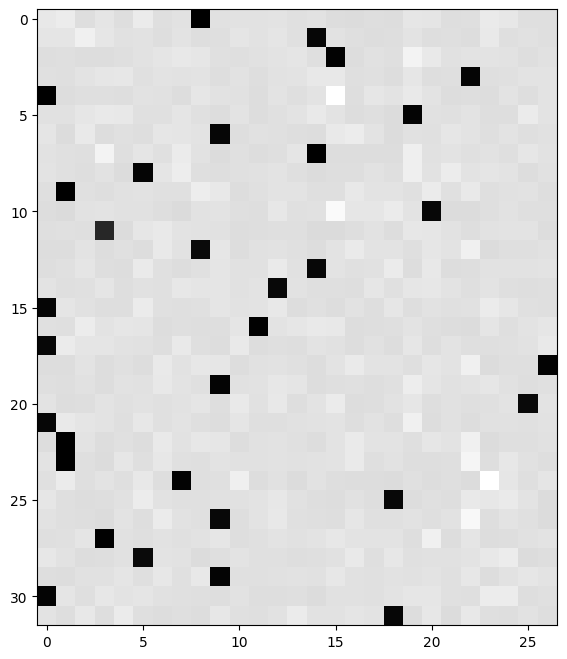

In [273]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [274]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# Derivatives done in apple notes

# -----------------
# YOUR CODE HERE :)
dhprebn =  ((bngain * (bnvar + 1e-5) ** -.5) / n) * (n * dhpreact - dhpreact.sum(0) - (n / (n - 1)) * bnraw * (dhpreact * bnraw).sum(0))
# bnvar_inv = (bnvar + 1e-5)**-0.5, so
dhprebn =  (bngain * bnvar_inv / n) * (n * dhpreact - dhpreact.sum(0) - (n / (n - 1)) * bnraw * (dhpreact * bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [290]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # What we calculated before 
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(dim=0)

    # tanh
    dhpreact = (1 - h**2) * dh

    # batchnorm
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn =  (bngain * bnvar_inv / n) * (n * dhpreact - dhpreact.sum(0) - (n / (n - 1)) * bnraw * (dhpreact * bnraw).sum(0))

    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for j in range(Xb.shape[0]):
      for k in range(Xb.shape[1]):
        xind = Xb[j][k]
        dC[xind] += demb[j][k]

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/ 200000: 3.7623
  10000/ 200000: 2.1798
  20000/ 200000: 2.3891
  30000/ 200000: 2.3978
  40000/ 200000: 2.0080
  50000/ 200000: 2.4205
  60000/ 200000: 2.3581
  70000/ 200000: 2.0770
  80000/ 200000: 2.3311
  90000/ 200000: 2.2046
 100000/ 200000: 1.9202
 110000/ 200000: 2.3456
 120000/ 200000: 1.9567
 130000/ 200000: 2.4424
 140000/ 200000: 2.2714
 150000/ 200000: 2.1568
 160000/ 200000: 1.9546
 170000/ 200000: 1.7917
 180000/ 200000: 2.0698
 190000/ 200000: 1.9426


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [291]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [292]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070742607116699
val 2.110607385635376


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [293]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mon.
ammyah.
see.
mad.
ryla.
renyra.
endraege.
dered.
elin.
shi.
jen.
eden.
sana.
arleigh.
malara.
nosalbergihimiest.
jair.
jennex.
terofkus.
macder.
